In [ ]:
from matplotlib import pyplot as plt
import numpy as np

import torch
from groundtruth import Map3d, Trajectory
from integration import render
from sample import make_pose

torch.set_default_tensor_type('torch.cuda.FloatTensor')


map = Map3d('data/map.mat')
traj = Trajectory('data/traj.mat')

rmin = 0
rmax = 5
dmin = -5
dmax = 5

r = torch.linspace(rmax, rmin, 50).cuda()
d = torch.linspace(dmin, dmax, 50).cuda()
d = d[torch.abs(d) > 0.01]


fig, axs = plt.subplots(6, 6, figsize=(24, 24))
axs = axs.reshape(-1)

for i, ax in enumerate(axs):
    t = int(i * traj.velocity.shape[0] / len(axs))
    pose = make_pose(
        traj.velocity[t, :].squeeze(),
        traj.position[t, :].squeeze(),
        traj.orientation[t, :, :].squeeze(), theta_lim=torch.pi * 0.5, phi_lim=torch.pi * 0.5)

    frame = render(map.sample_trilinear, r, d, pose, n=1440, k=1440)
    _frame = frame.cpu().numpy()
    ax.imshow(_frame, extent=[dmin, dmax, rmin, rmax], aspect='auto')
    ax.set_title(t)

In [ ]:
from scipy.io import loadmat

class Model(torch.nn.Module):
    def __init__(self, mapfile):
        super().__init__()
        map = loadmat(mapfile)
        self.x = torch.Tensor(map['x']).double()
        self.y = torch.Tensor(map['y']).double()
        self.z = torch.Tensor(map['z']).double()
        self.v = torch.nn.Parameter(torch.zeros(map['v'].shape).double())
        resx, resy, resz = self.v.shape
        ppmx = 1 / (self.x[1, 0, 0] - self.x[0, 0, 0])
        ppmy = 1 / (self.y[0, 1, 0] - self.y[0, 0, 0])
        ppmz = 1 / (self.z[0, 0, 1] - self.z[0, 0, 0])
        self.res = torch.Tensor([resx, resy, resz]).cuda()
        self.ppm = torch.Tensor([ppmx, ppmy, ppmz]).cuda()

    def sample_nearest(self, xyz):
        return self.uvw2val(self.xyz2uvw_nearest(xyz))

    def sample_trilinear(self, xyz):
        uvw = self.xyz2uvw_floor(xyz)
        t = (xyz - self.uvw2xyz(uvw)) * self.ppm
        r = 1 - t
        output = self.uvw2val(uvw + torch.Tensor([0, 0, 0]).long()) * r[:, 0] * r[:, 1] * r[:, 2]
        output += self.uvw2val(uvw + torch.Tensor([0, 0, 1]).long()) * r[:, 0] * r[:, 1] * t[:, 2]
        output += self.uvw2val(uvw + torch.Tensor([0, 1, 0]).long()) * r[:, 0] * t[:, 1] * r[:, 2]
        output += self.uvw2val(uvw + torch.Tensor([0, 1, 1]).long()) * r[:, 0] * t[:, 1] * t[:, 2]
        output += self.uvw2val(uvw + torch.Tensor([1, 0, 0]).long()) * t[:, 0] * r[:, 1] * r[:, 2]
        output += self.uvw2val(uvw + torch.Tensor([1, 0, 1]).long()) * t[:, 0] * r[:, 1] * t[:, 2]
        output += self.uvw2val(uvw + torch.Tensor([1, 1, 0]).long()) * t[:, 0] * t[:, 1] * r[:, 2]
        output += self.uvw2val(uvw + torch.Tensor([1, 1, 1]).long()) * t[:, 0] * t[:, 1] * t[:, 2]
        return output

    def xyz2uvw_nearest(self, xyz):
        return torch.round(xyz * self.ppm + self.res / 2 - 0.5).long()

    def xyz2uvw_floor(self, xyz):
        return torch.floor(xyz * self.ppm + self.res / 2 - 0.5).long()

    def uvw2xyz(self, uvw):
        return (uvw + 0.5 - self.res / 2) / self.ppm

    def uvw2val(self, uvw):
        mask = torch.logical_and(0 <= uvw, uvw < self.res).all(dim=1)
        output = torch.zeros(mask.shape, dtype=torch.double)
        output[mask] = self.v[uvw[mask, 0], uvw[mask, 1], uvw[mask, 2]]
        return output

    def forward(self, xyz):
        return self.sample_trilinear(xyz)


In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(24, 8))
for row, m in zip(axs, [_map, model]):
    for i, ax in enumerate(row):
        t = i * 1500 + 555
        pose = make_pose(
            traj.velocity[t, :].squeeze(),
            traj.position[t, :].squeeze(),
            traj.orientation[t, :, :].squeeze())

        frame = render(m.sample_trilinear, r, d, pose)
        _frame = frame.cpu().detach().numpy()
        ax.imshow(_frame, extent=[dmin, dmax, rmin, rmax], aspect='auto')
        ax.set_title(t)

100%|██████████| 10/10 [00:01<00:00,  7.95it/s]


9.674245191597991e-05


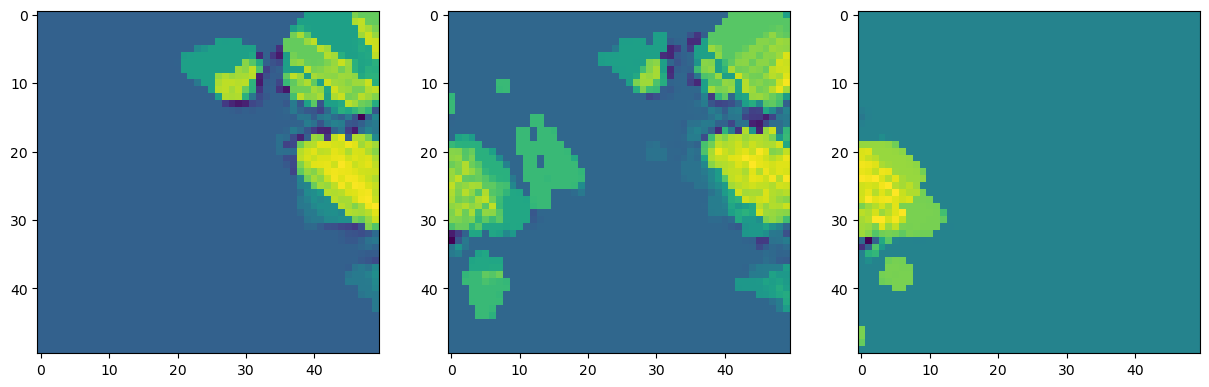

100%|██████████| 10/10 [00:01<00:00,  9.18it/s]


7.764279317940593e-05


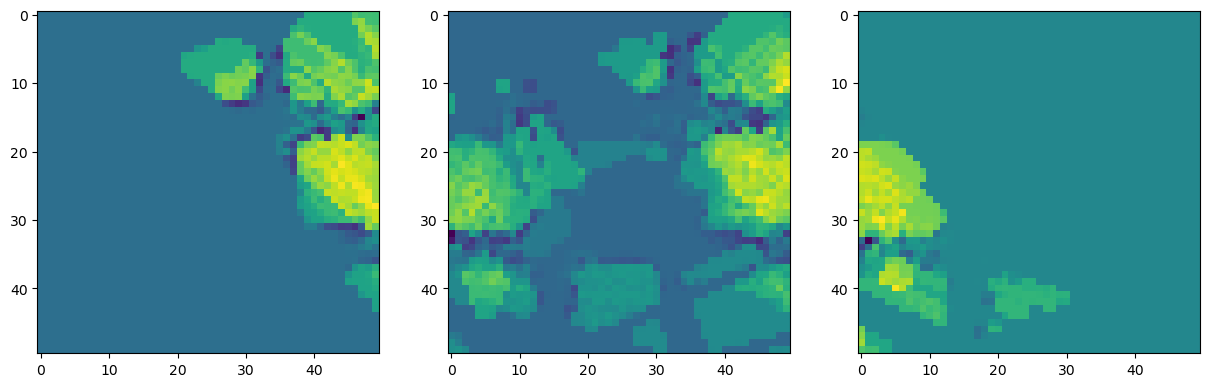

In [10]:
from tqdm import tqdm
from IPython.display import display

_map = Map3d('data/map.mat')
traj = Trajectory('data/traj.mat')
model = Model('data/map.mat')

r = torch.linspace(rmin, rmax, 50).cuda()
d = torch.linspace(dmin, dmax, 50).cuda()
d = d[torch.abs(d) > 0.01]

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def step():
    running_loss = 0.
    n = traj.velocity.shape[0]
    idx = torch.randperm(n)
    for i in tqdm(range(500)):
        t = idx[i]
        pose = make_pose(
            traj.velocity[t, :].squeeze(),
            traj.position[t, :].squeeze(),
            traj.orientation[t, :, :].squeeze())
        gt = render(_map.sample_trilinear, r, d, pose, k=360)

        optimizer.zero_grad()
        pred = render(model.forward, r, d, pose, k=360)
        loss = torch.mean((pred - gt)**2)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(running_loss / n)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    for ax, x in zip(axs, [10, 25, 40]):
        ax.imshow(model.v[:, :, x].cpu().detach().numpy())
    display(fig)
    plt.close()

for _ in range(10):
    step()